# Analysis of Why Patients Miss Their Scheduled Medical Appointments

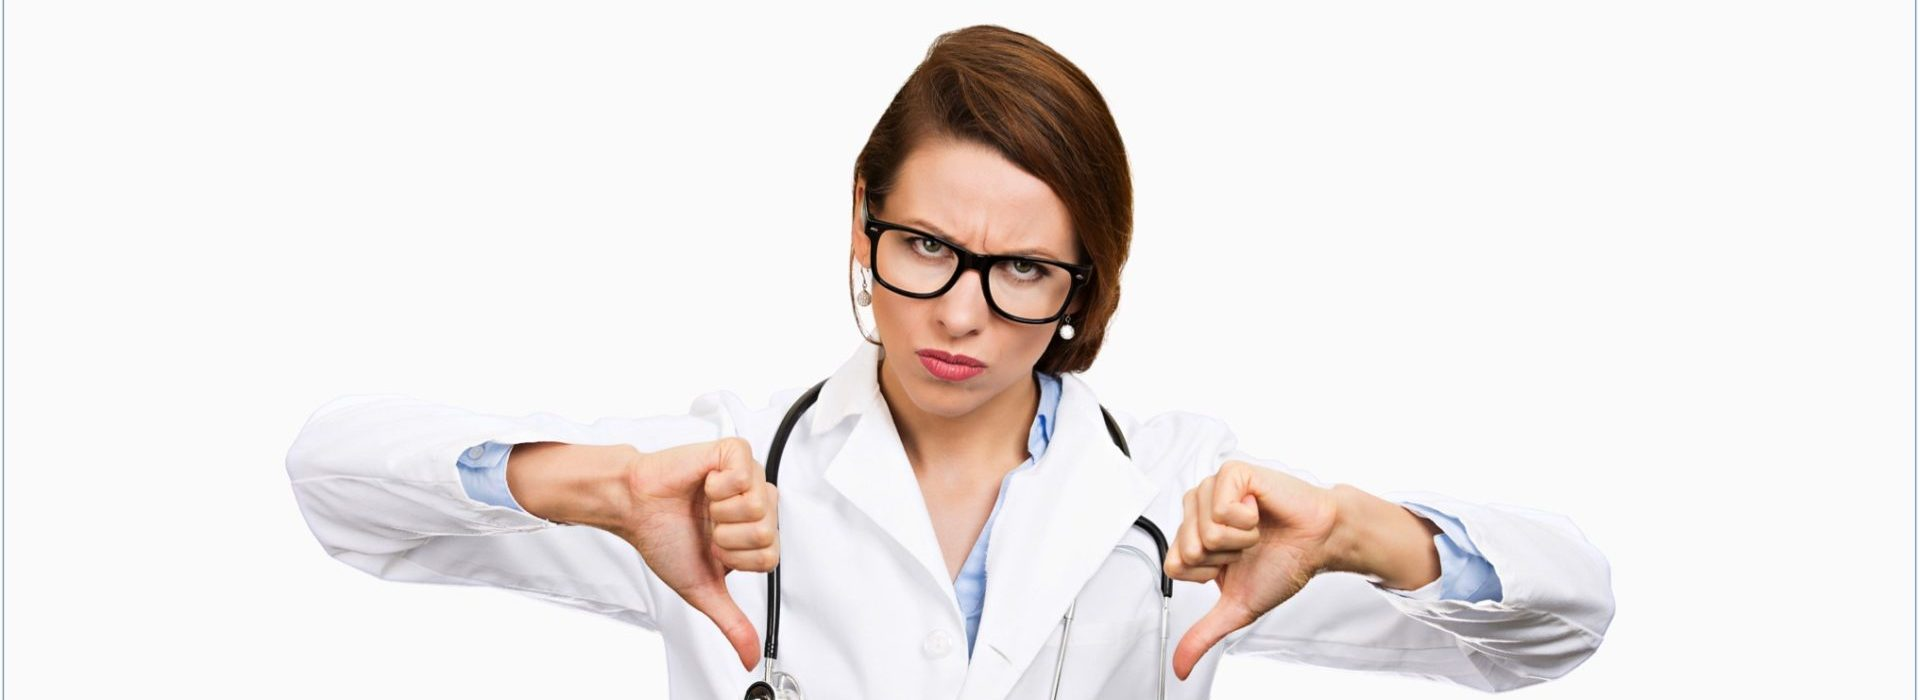

## Reza Ameli, Kevin Do, Richard Do

### CMSC320 Final Tutorial Fall 2019

## Introduction

We live in a busy world where we all have many things to worry about on a daily basis, so it is very easy for us to forget about something planned in our day since medical appointments are made months in advance. Our day to day routines usually just kick in without us even noticing, so when there is something that was planned months ago, it is easy to be lost in the jumble of things that is our daily agenda.

The purpose of this project is to figure out whether there is a way to predict if there was a way to predict if someone were to not show up to a medical appointment. This could prove beneficial, so that medical offices would be able to possibly determine how likely a patient will show up or not depending on certain characteristics derived from the data. As a result, medical offices would be able to remove or reschedule the appointments for those who didn't show up and possibly fit in appointments for patients who they know will show up.

## Working with the Data: Data Curation, Parsing and Management
We first import all the libraries that we need to work with the data which include: [pandas](https://pandas.pydata.org/pandas-docs/stable/), [numpy](https://numpy.org/doc/), [matplotlib](https://matplotlib.org/3.1.1/contents.html), [seaborn](https://seaborn.pydata.org/) and more.

In [98]:
# Necessary libraries and imports to complete this tutorial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Reading the Data
We drew our data from a [kaggle](https://www.kaggle.com/) database that collected information on [Medical Appointment No Shows](https://www.kaggle.com/joniarroba/noshowappointments)

In [99]:
appts = pd.read_csv("noshowappts.csv", sep=',')
appts.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


From the medical appointments dataset we got 14 columns which consisted of:
+ PatientId
+ AppointmentID
+ Gender
+ ScheduledDay (DataMarcacaoSonsulta)
+ AppointmentDay (DataAgendamento)
+ Age
+ Neighbourhood
+ [Scholarship](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia)
+ Hipertension
+ Diabetes
+ Alcoholism
+ Handcap
+ SMS_received
+ No-show

The columns should all be obvious and the 1s and 0s for certain categories represent true or false values while the only topic that may need an explanation is Scholarship where a link is provided for more information. SMS_Received might be a little unclear but from intuition it is whether the patient sent a SMS to the medical office or not notifying the office if he or she was going to make his or her appointment.

## Tidying and Modifying the Data
We can remove the PatientID, AppointmentID and Neighbourhood columns since we will not be needing the values from that data since they provide no useful information for the purposes of this tutorial.

However, the sections that we do care about the rest of the information within the dataframe. We went ahead and created two more columns in the dataframe to determine which season the appointment was scheduled and which season the appointment was supposed to take place. We did this to see whether patients were more likely to miss an appointment during a certain season.

Finally, we created two new dataframes; the first consisting of only people who are confirmed no-shows and the second only people who did show to their appointment. This will make our EDA simpler. 

In [100]:
#tidying data
appts = appts.drop(columns=['PatientId', 'AppointmentID', 'Neighbourhood','Handcap'])
sch_datetimes = []
appt_datetimes = []
sch_seasons = [] 
appt_seasons = []

def calc_season(season):
    if season == 1:
        return "Summer"
    elif season == 2:
        return "Autumn"
    elif sch_season == 3:
        return "Winter"
    elif season == 4:
        return "Spring"
    else:
        return "Unknown"

for index, row in appts.iterrows():
    sch_date = datetime.strptime(row['ScheduledDay'], "%Y-%m-%dT%H:%M:%SZ")
    appt_date = datetime.strptime(row['AppointmentDay'], "%Y-%m-%dT%H:%M:%SZ")
    
    sch_month = sch_date.month
    appt_month = appt_date.month
    sch_season = (sch_month%12 + 3)//3
    appt_season = (appt_month%12 + 3)//3
    
    sch_seasons.append(calc_season(sch_season))
    appt_seasons.append(calc_season(appt_season))
    
    sch_datetimes.append(datetime(sch_date.year, sch_date.month, sch_date.day, 
                                  sch_date.hour, sch_date.minute, sch_date.second))
    appt_datetimes.append(datetime(appt_date.year, appt_date.month, appt_date.day, 
                                   appt_date.hour, appt_date.minute, appt_date.second))

appts['ScheduledDay'] = sch_datetimes
appts['AppointmentDay'] = appt_datetimes
appts['ScheduledSeason'] = sch_seasons
appts['AppointmentSeason'] = appt_seasons

group_noshow = dict(tuple(appts.groupby('No-show')))
yes = group_noshow['Yes']
no = group_noshow['No']

appts.head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No-show,ScheduledSeason,AppointmentSeason
0,F,2016-04-29 18:38:08,2016-04-29,62,0,1,0,0,0,No,Autumn,Autumn
1,M,2016-04-29 16:08:27,2016-04-29,56,0,0,0,0,0,No,Autumn,Autumn
2,F,2016-04-29 16:19:04,2016-04-29,62,0,0,0,0,0,No,Autumn,Autumn
3,F,2016-04-29 17:29:31,2016-04-29,8,0,0,0,0,0,No,Autumn,Autumn
4,F,2016-04-29 16:07:23,2016-04-29,56,0,1,1,0,0,No,Autumn,Autumn


Now that we have all the columns that we want, we can move forward with our EDA!

## Exploratory Data Analysis
Here we wanted to see what kind of correlations we could take out of the data to hopefully figure out if certain health conditions make people more prone to missing a medical appointment. The three most prominent medical conditions that were presented in the dataset include: Hypertension, Diabetes and Alcoholism. We decided to ignore the Handicap column because there was not a sufficient amount of data to make it meaningful for analysis. We wanted to compare whether there were any differences between patients who did and did not show up for their appointments so we plotted plots for both of the groups.

STANDARDIZING THE DATA

In [101]:
std_age = appts.groupby('Gender')['Age'].std()
avg_age = appts.groupby('Gender')['Age'].mean()
stdized = []

for index, row in appts.iterrows():
    s = std_age.loc[row['Gender']]
    var = (row['Age'] - avg_age.loc[row['Gender']]) / s 
    stdized.append(var)
appts['std_age'] = stdized
appts.head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No-show,ScheduledSeason,AppointmentSeason,std_age
0,F,2016-04-29 18:38:08,2016-04-29,62,0,1,0,0,0,No,Autumn,Autumn,1.042914
1,M,2016-04-29 16:08:27,2016-04-29,56,0,0,0,0,0,No,Autumn,Autumn,0.911109
2,F,2016-04-29 16:19:04,2016-04-29,62,0,0,0,0,0,No,Autumn,Autumn,1.042914
3,F,2016-04-29 17:29:31,2016-04-29,8,0,0,0,0,0,No,Autumn,Autumn,-1.394433
4,F,2016-04-29 16:07:23,2016-04-29,56,0,1,1,0,0,No,Autumn,Autumn,0.772098


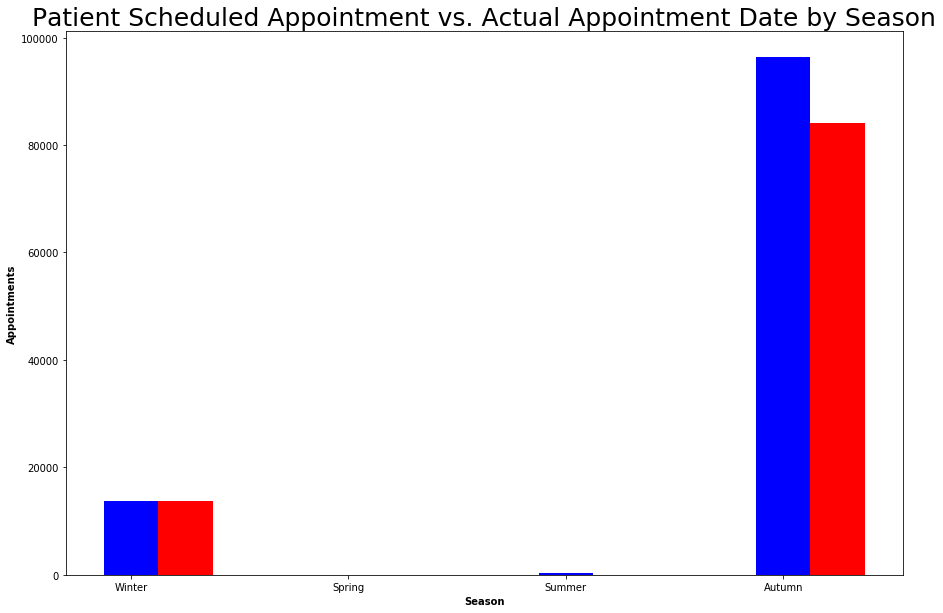

In [102]:
schedseason = appts[['ScheduledSeason', 'AppointmentSeason']]
countSched = {'Winter': 0, 'Spring': 0, 'Summer': 0, 'Autumn': 0}
countAppoint = {'Winter': 0, 'Spring': 0, 'Summer': 0, 'Autumn': 0}

for i, row in schedseason.iterrows():
    if row['ScheduledSeason'] == 'Winter':
        countSched['Winter'] = countSched.get('Winter', 0) + 1
    if row['AppointmentSeason'] == 'Winter':
        countAppoint['Winter'] = countAppoint.get('Winter', 0) + 1
    if row['ScheduledSeason'] == 'Spring':
        countSched['Spring'] = countSched.get('Spring', 0) + 1
    if row['AppointmentSeason'] == 'Spring':
        countAppoint['Spring'] = countAppoint.get('Spring', 0) + 1
    if row['ScheduledSeason'] == 'Summer':
        countSched['Summer'] = countSched.get('Summer', 0) + 1
    if row['AppointmentSeason'] == 'Summer':
        countAppoint['Summer'] = countAppoint.get('Summer', 0) + 1
    if row['ScheduledSeason'] == 'Autumn':
        countSched['Autumn'] = countSched.get('Autumn', 0) + 1
    if row['AppointmentSeason'] == 'Autumn':
        countAppoint['Autumn'] = countAppoint.get('Autumn', 0) + 1

barWidth = .25
fig = plt.figure(figsize=(15,10))

r1 = range(len(countSched))
r2 = [x + barWidth for x in r1]
plt.bar(r1, list(countSched.values()), color='b', width=barWidth, align = 'center')
plt.bar(r2, list(countAppoint.values()), color='r', width=barWidth, align = 'center')
plt.xlabel('Season', fontweight='bold')
plt.ylabel('Appointments', fontweight='bold')
plt.title("Patient Scheduled Appointment vs. Actual Appointment Date by Season", fontsize='25')
plt.xticks(range(len(countSched)), list(countSched.keys()))
plt.show()

Initially, we thought that the season would have some kind of impact on whether patients would attend their appointments such as changing season with cold and flu season. However, upon further analysis, we found that a majority of the appointments were scheduled during the Brazil's Autumn season. If we had a larger dataset then this would prove to be a more reliable reason for patient attendance, but this dataset did not account for the rest of the year.

<Figure size 1080x720 with 0 Axes>

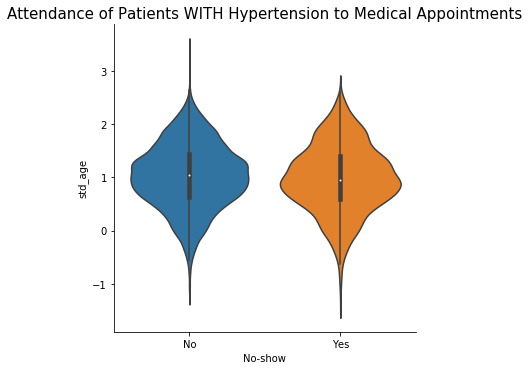

In [103]:
hibloodpressure = appts[appts['Hipertension'] == 1]
fig = plt.figure(figsize=(15,10))
sns.catplot(x='No-show',y='std_age',data= hibloodpressure,kind="violin",order=['No','Yes'])
plt.title("Attendance of Patients WITH Hypertension to Medical Appointments", fontsize=15)
plt.show()

<Figure size 1080x720 with 0 Axes>

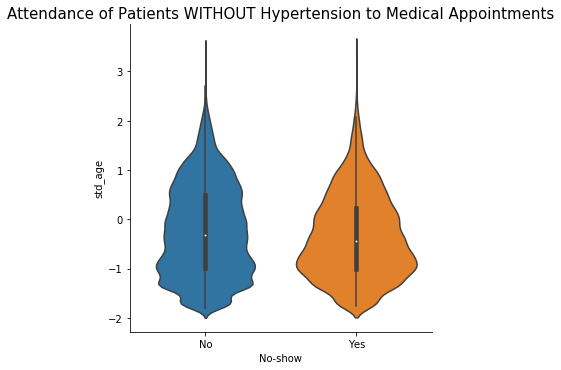

In [104]:
hibloodpressure = appts[appts['Hipertension'] == 0]
fig = plt.figure(figsize=(15,10))
sns.catplot(x='No-show',y='std_age',data= hibloodpressure,kind="violin",order=['No','Yes'])
plt.title("Attendance of Patients WITHOUT Hypertension to Medical Appointments", fontsize=15)
plt.show()

The medians between the group who does show up and doesn't show varies by a few years between females and males. However the probability between the two groups varies a bit more slightly with males than females while the peak probability of females missing an appointment is greater than the group of females who do show up. More males who have high blood pressure are more likely to show up to their medical appointments than females are. But there is still a high chance that people with high blood pressure will attend their appointments. While around the probability to either show up or not shot up is still in the 60s range there is not direct correlation we can derive from this plot.

<Figure size 1080x720 with 0 Axes>

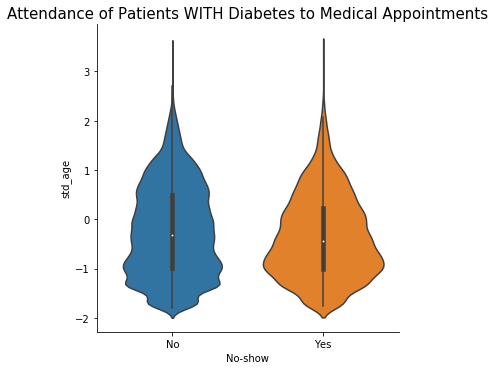

In [105]:
diabetes = appts[appts['Diabetes'] == 1]
fig = plt.figure(figsize=(15,10))
sns.catplot(x='No-show',y='std_age',data= hibloodpressure,kind="violin",order=['No','Yes'])
plt.title("Attendance of Patients WITH Diabetes to Medical Appointments", fontsize=15)
plt.show()

<Figure size 1080x720 with 0 Axes>

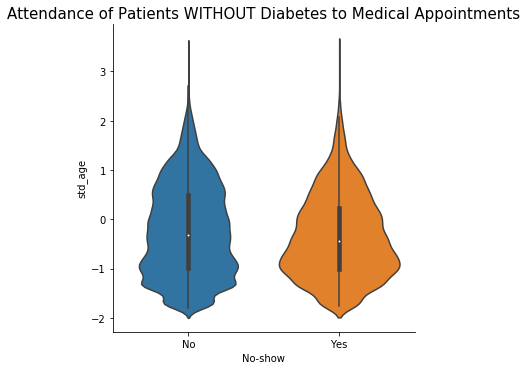

In [106]:
diabetes = appts[appts['Diabetes'] == 0]
fig = plt.figure(figsize=(15,10))
sns.catplot(x='No-show',y='std_age',data= hibloodpressure,kind="violin",order=['No','Yes'])
plt.title("Attendance of Patients WITHOUT Diabetes to Medical Appointments", fontsize=15)
plt.show()

The medians patients with diabetes lies around 60 years again but the probability for men and women to attend their appointments are higher when they are older than 60 years old. However, the probability for men and women to miss their appointments are greater when they are younger than 60 years old. This could show that people are not as concerned to attending appointments since they believe that diabetes is not as high of a risk as other health concerns. This is a promising result and we will take this into account in our further analysis. 

<Figure size 1080x720 with 0 Axes>

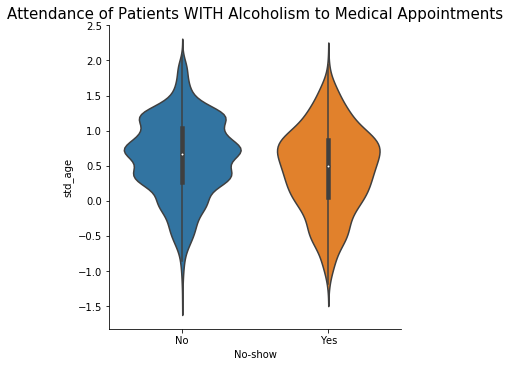

In [107]:
alcoholism = appts[appts['Alcoholism'] == 1]
fig = plt.figure(figsize=(15,10))
sns.catplot(x='No-show',y='std_age',data= alcoholism,kind="violin")
plt.title("Attendance of Patients WITH Alcoholism to Medical Appointments",fontsize=15)
plt.show()

<Figure size 1080x720 with 0 Axes>

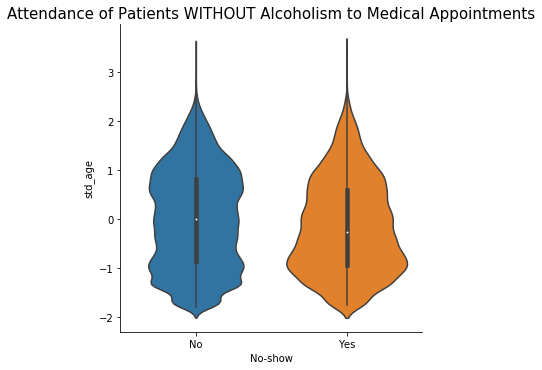

In [108]:
alcoholism = appts[appts['Alcoholism'] == 0]
fig = plt.figure(figsize=(15,10))
sns.catplot(x='No-show',y='std_age',data= alcoholism,kind="violin")
plt.title("Attendance of Patients WITHOUT Alcoholism to Medical Appointments",fontsize=15)
plt.show()

This is where it gets a bit interesting because now there's more data for males now when it relates to alcoholism (who would've knew). Anywho, the median age for people who do and do not show up to their appointments drop to a lower age range like 50 for males and 45 for females. There is a slight spike increase in people showing up to medical appointments if they are alcoholics especially for older males. However, right around the median is where a lot of the male and female alcoholics do not attend their appointments. 

The above graphs show us that gender has an impact when determining if someone will not show up to their appointment. This is compounded with the fact that this dataset has a 65%/35% Female to Male split. As we begin to analyze the whole dataset this could cause skew and inconsistency in our results. So, we will need to create a variable to standarize this as we proceed to analyze the whole dataset. The following code creates a column of standardized age values. This is done by first calculating the standard deviation and mean for each age. Then we use the formula ((age - avg_age) / std_dev). Then the column is added to the dataframe.

In [ ]:
std_age = appts.groupby('Gender')['Age'].std()
avg_age = appts.groupby('Gender')['Age'].mean()
stdized = []

for index, row in appts.iterrows():
    s = std_age.loc[row['Gender']]
    var = (row['Age'] - avg_age.loc[row['Gender']]) / s 
    stdized.append(var)
appts['std_age'] = stdized
appts.head()

Now we want to analyze SMS_received using our standarized variable. This will allow us to determine if a patient receiving a text reminder impacts if they will show up to an appointment.

In [ ]:
sms1 = appts[appts['SMS_received'] == 1]
fig = plt.figure(figsize=(15,10))
sns.catplot(x='No-show', y='std_age', data=sms1, kind="violin", order=['No', 'Yes'])
plt.title("Attendance of Patients WITH an SMS reminder to Medical Appointments", fontsize=15)
plt.show()

In [ ]:
sms0 = appts[appts['SMS_received'] == 0]
fig = plt.figure(figsize=(15,10))
sns.catplot(x='No-show', y='std_age', data=sms0, kind="violin")
plt.title("Attendance of Patients WITHOUT an SMS reminder to Medical Appointments", fontsize=15)
plt.show()

Somewhat suprisingly we can see that whether the patient received a text or not actually does not really impact the distribution of the data. Thus we can infer that it does not have much of an impact on whether or not the patient shows up for the appointment. 

In [ ]:
scholarship = appts[appts['Scholarship'] == 1]
fig = plt.figure(figsize=(15,10))
sns.catplot(x='No-show',y='std_age',data= scholarship, kind="violin",order=['No','Yes'])
plt.title("Attendance of Patients WITH a Scholarship to Medical Appointments")
plt.show()

In [ ]:
scholarship = appts[appts['Scholarship'] == 0]
fig = plt.figure(figsize=(15,10))
sns.catplot(x='No-show',y='std_age',data= scholarship, kind="violin",order=['No','Yes'])
plt.title("Attendance of Patients WITHOUT a Scholarship to Medical Appointments")
plt.show()

Here we investigate the likeliness of a patient attending his or her medical appointment due to his or her scholarship. When the data is talking about the scholarship, it means if he or she receives a scholarship then he or she is less fortunate and needs the scholarship and if he or she is fortunate then he or she will not require the scholarship. From the plots of the data, it seems that people who are more poor are more likely to miss his or her appointment.

## Hypothesis Testing and Machine Learning

In [ ]:
for index, row in appts.iterrows():
    if row['No-show'] == 'No':
        appts.at[index, 'noshow_val'] = np.int64(0)
    else:
        appts.at[index, 'noshow_val'] = np.int64(1)

x = appts['noshow_val'].values.reshape(-1,1)
y = appts['std_age'].values.reshape(-1,1)
reg = LinearRegression().fit(x, y)
coef = reg.coef_
intercept = reg.intercept_
print(coef, intercept)

In [ ]:
est = []
for x in appts['std_age'].values:
    est.append(reg.predict(x.reshape(-1,1))[0][0])
    
appts["est"] = est
appts["residual"] = appts["std_age"] - appts["est"]
fig = plt.figure(figsize=(15,10))
sns.violinplot(x="No-show", y="residual", data=appts)

This residual created above from the linear regression prediction compared to no-shows, so the regression predicted the ages of no-shows and the distribution seems to show that younger people are more likely to be a no-show.

In [ ]:
fig = plt.figure(figsize=(15,10))
sns.violinplot(x="Gender", y="residual", data=appts)

Here we can see some discrepancy between the two genders interaction with the residual, so let's run a linear regression to see if we need an interaction term between Age and Gender.

In [ ]:
temp = appts.groupby('Gender')
genders = dict(list(temp))

fig = plt.figure(figsize=(15,10))
male = genders['M']
ax = sns.regplot(x="noshow_val", y="std_age", data=male)
plt.title("Linear Regression for Male No-Shows", fontsize=15)
plt.show()

fig = plt.figure(figsize=(15,10))
female = genders['F']
ax = sns.regplot(x="noshow_val", y="std_age", data=female)
plt.title("Linear Regression for Female No-Shows", fontsize=15)
plt.show()

Based on this plot it is not necessary to create an interaction term between age and gender since the standardization from earlier in the project has made the two regressions consistent. 

In [ ]:
# Add a column to the dataframe representing number of appointments
appts['appt_val'] = np.int64(1)

# No-Show Factors: Gender, Scholarship, Hipertension, Diabetes, Alcoholism, Handcap, SMS_received
# Create dataframe to sum up No-Shows and Number of appointments based on these factors
factors = appts.groupby(['Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received'], \
            as_index=False)['noshow_val', 'appt_val'].sum()

# Creating the No-Show ratio based on number of appointments missed vs number of appointments of that type
factors['noshow_ratio'] = pd.to_numeric(factors['noshow_val']) / pd.to_numeric(factors['appt_val'])

for index, row in factors.iterrows():
    if row['Gender'] == 'M':
        factors.at[index, 'Gender'] = np.int64(0)
    else:
        factors.at[index, 'Gender'] = np.int64(1)
        
factors.head()

In [ ]:
X = factors.drop('noshow_ratio', axis=1)
y = factors['noshow_ratio']

# Split data into Train and Test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)
X_train['noshow_ratio'] = y_train

# Fit the Linear Regression on Train split
reg = smf.ols(formula='noshow_ratio ~ C(Gender) + C(Scholarship) + C(Hipertension) + \
        C(Diabetes) + C(Alcoholism) + C(SMS_received)', data=X_train).fit()

# Predict using Test split
pred = reg.predict(X_test)

# Plot how the predicted win_ratio compares to actual win ratio
f, ax = plt.subplots(figsize=(15,10))
plt.title('No-Show Data Distribution for Actual and Predicted')
sns.distplot(y_test, hist=False, label="Actual", ax=ax)
sns.distplot(pred, hist=False, label="Linear Regression Predictions", ax=ax)

plt.show()

In [ ]:
from scipy.stats import f

# F-Test to evaluate goodness of fit
test = reg.f_test(np.identity(len(reg.params)))
print('Model - Calculated F-Statistic: ' + str(f.ppf(.95,test.df_num,test.df_denom)) + \
        ' F-Value: ' + str(test.fvalue[0][0]) + ' P-Value: ' + str(test.pvalue))

With the size of the p-value we can see that our prediction model is actually pretty sucessful in determining the likelihood of a no-show. 

## Conclusion

Patients deciding whether they show up to their doctor's appointments is very indicative of their situation and the factors that cause them to miss their appointment provides even further insight as to the status of the health care system, the status of the patients, and in essence the status of society and social stigmas that are cast upon everyone who is a part of the society. In analyzing the EDA portion of our project several conclusions can be made based on the factors that correlate to the reason why patients miss their appointments. 

Alcoholism, in our EDA portion one of the points that we looked at was how the factor of alcoholism plays into patients attending their doctors appointments or missing their doctors appointments. Based on our graphs we can see that typically those who suffer from alcoholism had a higher tendency to miss their doctors appointments. From this data we are able to infer a few things about alcoholism and how it affects patients. Those with alcoholism may miss their doctor's appointments because they are ashamed of the condition in which they are being afflicted with, and because of this they may feel like it is unnecessary to go to the doctor to be shamed about their condition. This speaks to social stigmas that are associated with alcoholism and what it does to those who need help. Alcoholism is a disease and going to the doctor is the first step to make sure patients are treated, whoever with the lingering stigmas that paint alcoholism in such a bad light patients are hesitant to reach out for the help that sometimes they so desperately need. 

Diabetes and Hypertension, these medical conditions are typically warning signs and indicators of heart disease and other diseases related to cardiovascular health. Based on our graphs we can see that patients with these health conditions who are older are more likely to go to the doctor, while those who are younger are typically less likely to go to the doctors. From this we can infer that older people are more likely to go to the doctor because these conditions are usually developed later in life and sometimes they are associated with unhealthy diet, but with old age hypertension is something that more people should be aware of. These conditions sometimes are indicators to heart attack,heart disease, and stroke which is why older people must be more cognizant of this, thus they are more likely to go to the doctor because they want to be healthy and live long lives. Another thing that we can infer from this is how the health care system works. In Brazil, they operate with a universal health care system, so every single person has health care and thus they can decide when they want to go to the doctor because it is a constitutional  right. This [article](https://www.theatlantic.com/health/archive/2014/05/the-struggle-for-universal-healthcare/361854/) discusses more about Brazil's healthcare system. The Brazilian healthcare system is like that of most European countries, however because they country's population is so large it puts strain on this system. This is another reason as to why younger people are less inclined to go to the doctors as well because of the lack of treatment sometimes associated with Brazilian healthcare. This example of Brazilian health care is important for us, Americans, because it provides us better insight with how we should tackle the way that our health care works. Currently, we use a privatized health care system, and we have Medicare for old people because without it there would be a "death spiral" with the insurance market. This [article](https://www.investopedia.com/terms/d/deathspiral.asp) talks more about the death spiral with health insurance. In conclusion, we can determine how to accurately gauge the healthcare needs of our citizens based on these pre-existing health care conditions and how it affects the health care market. 

Overall, the healthcare of a nation is a good indicator of what the status of it's citzens and its infrastructure are.
and then i moved the plots to the bottom.
